In [22]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, terminated):
        self.buffer.append((state, action, reward, next_state, terminated))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, terminateds = zip(*transitions)
        return np.array(states), actions, rewards, np.array(next_states), terminateds
    
    def size(self):
        return len(self.buffer)
    

class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        return self.fc2(x)
    
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr = learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            #print(state)
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            #print(state.shape)
            action = self.q_net(state).argmax().item()
        return action
    

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        terminateds = torch.tensor(transition_dict['terminateds'], dtype=torch.float).view(-1, 1).to(self.device)
        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_net(next_states).max(1)[0].view(-1, 1)
        #print(type(max_next_q_values))
        #print(rewards.shape, max_next_q_values.shape, terminateds.shape)
        q_targets = rewards + self.gamma * max_next_q_values * (1.0 - terminateds)

        dqn_loss = torch.mean(torch.nn.functional.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.count += 1



lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cpu") #torch.device("cuda") if torch.cuda.is_available () else torch.device("cpu")
env_name = "CartPole-v1"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

env = gym.make(env_name)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.close()

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

def train(num_episodes):
    reward_stat = np.zeros(num_episodes)
    env = gym.make(env_name)
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            replay_buffer.add(state, action, reward, next_state, terminated)
            state = next_state
            total_reward += reward
            if replay_buffer.size() > minimal_size:
                states, actions, rewards, next_states, terminateds = replay_buffer.sample(batch_size)
                transition_dict = {
                    "states":states,
                    "actions":actions,
                    "rewards":rewards,
                    "next_states":next_states,
                    "terminateds":terminateds,
                }
                agent.update(transition_dict)
            if terminated or truncated:
                break
        if episode*10 % num_episodes == 0:
            print("episode:", episode, "total_reward:",total_reward)
        reward_stat[episode] = total_reward
    env.close()
    return reward_stat

def test(num_episodes):
    env = gym.make(env_name,render_mode="human")
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        #print("episode:", episode, "total_reward:",total_reward)
    env.close()



episode: 0 total_reward: 9.0
episode: 50 total_reward: 10.0
episode: 100 total_reward: 25.0
episode: 150 total_reward: 500.0
episode: 200 total_reward: 315.0
episode: 250 total_reward: 192.0
episode: 300 total_reward: 309.0
episode: 350 total_reward: 286.0
episode: 400 total_reward: 223.0
episode: 450 total_reward: 500.0


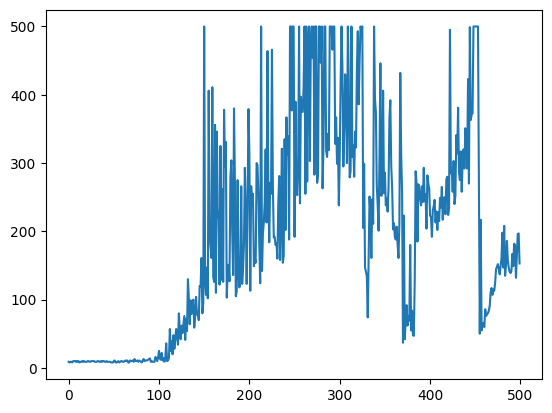

In [26]:
reward_stat = train(500)
plt.plot(range(len(reward_stat)), reward_stat)
test(1)

In [50]:

a = np.arange(8.).reshape(2,2,2)
m0 = a.mean(0)
m1 = a.mean(1)
m2 = a.mean(2)

a,m0,m1,m2
dir(torch)

['AVG',
 'AggregationType',
 'AliasDb',
 'Any',
 'AnyType',
 'Argument',
 'ArgumentSpec',
 'AwaitType',
 'BFloat16Storage',
 'BFloat16Tensor',
 'BenchmarkConfig',
 'BenchmarkExecutionStats',
 'Block',
 'BoolStorage',
 'BoolTensor',
 'BoolType',
 'BufferDict',
 'ByteStorage',
 'ByteTensor',
 'CallStack',
 'Callable',
 'Capsule',
 'CharStorage',
 'CharTensor',
 'ClassType',
 'Code',
 'CompilationUnit',
 'CompleteArgumentSpec',
 'ComplexDoubleStorage',
 'ComplexFloatStorage',
 'ComplexType',
 'ConcreteModuleType',
 'ConcreteModuleTypeBuilder',
 'DeepCopyMemoTable',
 'DeserializationStorageContext',
 'DeviceObjType',
 'Dict',
 'DictType',
 'DisableTorchFunction',
 'DisableTorchFunctionSubclass',
 'DispatchKey',
 'DispatchKeySet',
 'DoubleStorage',
 'DoubleTensor',
 'EnumType',
 'ErrorReport',
 'ExcludeDispatchKeyGuard',
 'ExecutionPlan',
 'FatalError',
 'FileCheck',
 'FloatStorage',
 'FloatTensor',
 'FloatType',
 'FunctionSchema',
 'Future',
 'FutureType',
 'Generator',
 'Gradient',
 'Grap